Below is a **Jupyter Notebook example** that demonstrates **each pattern** with a **small state graph** to visualize the control flow or orchestration logic. Each pattern includes:

1. **A brief description** of what the pattern does.  
2. **Node logic** appropriate for that pattern.  
3. **Graph construction** (nodes + edges).  
4. **Graph compilation** and **visual display** using `langgraph`.  

---


In [1]:
################################################################################
# Agent Design Patterns with Graph Visualization
################################################################################

# If needed, install langgraph:
# !pip install langgraph

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# We'll use a single State class for convenience across all patterns
class State:
    def __init__(self):
        # Use a dictionary to hold pattern-specific data, or expand as needed
        self.data = {}
        self.history = []
        self.mood = None
        self.confidence = 1.0
        self.query = None
        self.context = None


## 1. Simple Agent Pattern

**Description**:  
A Simple Agent is a straightforward, single-step process. It might greet the user or return a basic response without any advanced logic or branching.


=== Simple Agent Pattern Graph ===


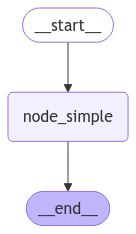

In [2]:
# 1) Define node logic
def node_simple(state: State):
    """A trivial 'Hello World' node."""
    print("node_simple: Hello from SimpleAgent!")
    return state

# 2) Build the graph
builder_simple = StateGraph(State)
builder_simple.add_node("node_simple", node_simple)

# 3) Add transitions
builder_simple.add_edge(START, "node_simple")  # Start -> node_simple
builder_simple.add_edge("node_simple", END)    # node_simple -> END

# 4) Compile & display
graph_simple = builder_simple.compile()
print("=== Simple Agent Pattern Graph ===")
display(Image(graph_simple.get_graph().draw_mermaid_png()))


## 2. Graph-Based Agent Pattern

**Description**:  
Uses a directed graph to control a conversation or process flow. Nodes are tasks or states, and edges define transitions (including conditional logic).



=== Graph-Based Agent Pattern ===


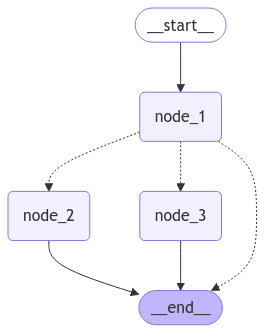

In [3]:
# For demonstration, we'll reuse the node_1, node_2, node_3 logic from our example.

def node_1(state: State):
    state.mood = "happy"
    print("node_1 executed; setting mood='happy'")
    return state

def node_2(state: State):
    print("node_2 executed; finishing in a happy mood!")
    return state

def node_3(state: State):
    print("node_3 executed; finishing in a not-so-good mood!")
    return state

def decide_mood(state: State):
    if state.mood == "happy":
        return ["node_2"]
    else:
        return ["node_3"]

# 2) Build the graph
builder_graph = StateGraph(State)
builder_graph.add_node("node_1", node_1)
builder_graph.add_node("node_2", node_2)
builder_graph.add_node("node_3", node_3)

# 3) Add transitions
builder_graph.add_edge(START, "node_1")
builder_graph.add_conditional_edges("node_1", decide_mood)
builder_graph.add_edge("node_2", END)
builder_graph.add_edge("node_3", END)

# 4) Compile & display
graph_graph = builder_graph.compile()
print("\n=== Graph-Based Agent Pattern ===")
display(Image(graph_graph.get_graph().draw_mermaid_png()))


## 3. Chain-of-Agents (Chain) Pattern

**Description**:  
Chains a series of sub-tasks (agents) together so the output of one is the input to the next. Typical for multi-step transformations.



=== Chain-of-Agents Pattern ===


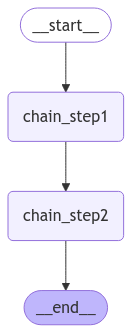

In [4]:
# 1) Define node logic
def node_chain_step1(state: State):
    # For demonstration, we'll uppercase the data
    user_input = state.data.get("user_input", "")
    transformed = user_input.upper()
    state.data["transformed"] = transformed
    print("node_chain_step1: Transformed to uppercase =", transformed)
    return state

def node_chain_step2(state: State):
    # Next step might measure length
    transformed = state.data.get("transformed", "")
    length = len(transformed)
    state.data["length"] = length
    print(f"node_chain_step2: Length of transformed input = {length}")
    return state

# 2) Build the graph
builder_chain = StateGraph(State)
builder_chain.add_node("chain_step1", node_chain_step1)
builder_chain.add_node("chain_step2", node_chain_step2)

# 3) Add transitions (a simple linear chain)
builder_chain.add_edge(START, "chain_step1")
builder_chain.add_edge("chain_step1", "chain_step2")
builder_chain.add_edge("chain_step2", END)

# 4) Compile & display
graph_chain = builder_chain.compile()
print("\n=== Chain-of-Agents Pattern ===")
display(Image(graph_chain.get_graph().draw_mermaid_png()))


## 4. Router Pattern

**Description**:  
A Router decides **which** specialized agent (or node) to send the input to, often based on some classification or keyword detection.



=== Router Pattern ===


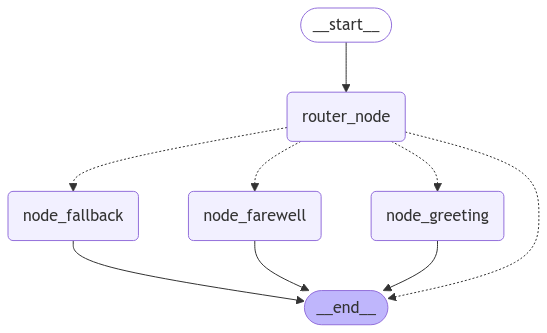

In [6]:
# 1) Define node logic
def node_greeting(state: State):
    print("node_greeting: Hello! How can I help you today?")
    return state

def node_farewell(state: State):
    print("node_farewell: Goodbye! Have a nice day!")
    return state

def node_fallback(state: State):
    print("node_fallback: I'm not sure what you need. Could you rephrase?")
    return state

def node_router(state: State):
    # This can be a simple pass-through; the real routing 
    # logic is in router_decision, so we just return state.
    return state

def router_decision(state: State):
    """Decide the route based on user_input keywords."""
    user_input = state.data.get("user_input", "").lower()
    if "hello" in user_input:
        return ["node_greeting"]
    elif "bye" in user_input:
        return ["node_farewell"]
    else:
        return ["node_fallback"]

# 2) Build the graph
builder_router = StateGraph(State)
builder_router.add_node("router_node", node_router)   # ADD THIS
builder_router.add_node("node_greeting", node_greeting)
builder_router.add_node("node_farewell", node_farewell)
builder_router.add_node("node_fallback", node_fallback)

# 3) Add transitions
builder_router.add_edge(START, "router_node")  
builder_router.add_conditional_edges("router_node", router_decision)
builder_router.add_edge("node_greeting", END)
builder_router.add_edge("node_farewell", END)
builder_router.add_edge("node_fallback", END)

# 4) Compile & display
graph_router = builder_router.compile()
print("\n=== Router Pattern ===")
display(Image(graph_router.get_graph().draw_mermaid_png()))


## 5. Agent with Memory Pattern

**Description**:  
Agent memory tracks conversation or data across steps. In graph form, you can visualize a node that appends to memory, then another node that uses that memory.



=== Agent Memory Pattern ===


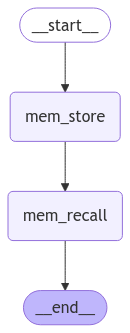

In [7]:
# 1) Define node logic
def node_memory_store(state: State):
    """Stores user input into state's history."""
    user_input = state.data.get("user_input", "")
    state.history.append(user_input)
    print(f"node_memory_store: Stored input '{user_input}' in history => {state.history}")
    return state

def node_memory_recall(state: State):
    """Demonstrates how we might recall and print the memory."""
    print("node_memory_recall: Current history =>", state.history)
    return state

# 2) Build the graph
builder_memory = StateGraph(State)
builder_memory.add_node("mem_store", node_memory_store)
builder_memory.add_node("mem_recall", node_memory_recall)

# 3) Add transitions
builder_memory.add_edge(START, "mem_store")
builder_memory.add_edge("mem_store", "mem_recall")
builder_memory.add_edge("mem_recall", END)

# 4) Compile & display
graph_memory = builder_memory.compile()
print("\n=== Agent Memory Pattern ===")
display(Image(graph_memory.get_graph().draw_mermaid_png()))


## 6. Assistant (Human-in-the-Loop) Pattern

**Description**:  
The Assistant attempts an automated response, but if it's not confident, it defers or escalates to a human node.



=== Assistant (Human-in-the-Loop) Pattern ===


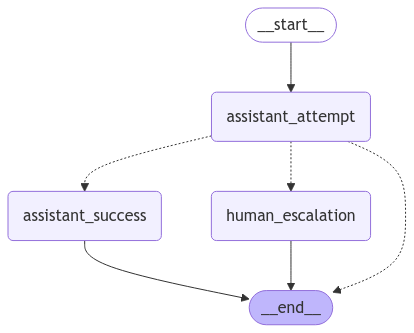

In [8]:
import random

# 1) Define node logic
def node_assistant_attempt(state: State):
    # Pretend we do some complex NLP analysis
    state.confidence = random.random()
    print(f"node_assistant_attempt: Confidence={state.confidence:.2f}")
    return state

def node_assistant_success(state: State):
    print("node_assistant_success: Automated response succeeded!")
    return state

def node_human_escalation(state: State):
    print("node_human_escalation: Escalating to human operator...")
    return state

def decide_confidence(state: State):
    if state.confidence >= 0.7:
        return ["assistant_success"]
    else:
        return ["human_escalation"]

# 2) Build the graph
builder_assistant = StateGraph(State)
builder_assistant.add_node("assistant_attempt", node_assistant_attempt)
builder_assistant.add_node("assistant_success", node_assistant_success)
builder_assistant.add_node("human_escalation", node_human_escalation)

# 3) Add transitions
builder_assistant.add_edge(START, "assistant_attempt")
builder_assistant.add_conditional_edges("assistant_attempt", decide_confidence)
builder_assistant.add_edge("assistant_success", END)
builder_assistant.add_edge("human_escalation", END)

# 4) Compile & display
graph_assistant = builder_assistant.compile()
print("\n=== Assistant (Human-in-the-Loop) Pattern ===")
display(Image(graph_assistant.get_graph().draw_mermaid_png()))


## 7. Multi-Agent with Agentic RAG Pattern

**Description**:  
Shows a simplified flow for a RAG (Retrieval-Augmented Generation) approach with multiple sub-agents:

1. **Retrieve** context based on a query.  
2. **Reason** about it.  
3. **Generate** a final response.  



=== Multi-Agent with Agentic RAG Pattern ===


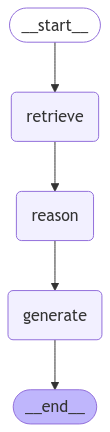

In [9]:
# 1) Define node logic
def node_retrieve(state: State):
    """Mimics retrieval from a knowledge base (stub)."""
    user_query = state.data.get("user_input", "").lower()
    # Some mock data
    kb = {
        "weather": "It's typically sunny in California this time of year.",
        "python": "Python is a popular high-level programming language."
    }
    state.context = kb.get(user_query, "No relevant data found.")
    print(f"node_retrieve: Retrieved context => '{state.context}'")
    return state

def node_reason(state: State):
    """Simulated reasoning about the retrieved context."""
    user_query = state.data.get("user_input", "")
    context = state.context
    reasoned = f"[Reasoned] Using context '{context}' to address query '{user_query}'."
    state.data["reasoned_output"] = reasoned
    print("node_reason:", reasoned)
    return state

def node_generate(state: State):
    """Generate the final answer from reasoned text."""
    reasoned_text = state.data.get("reasoned_output", "")
    final_answer = f"Final Answer: {reasoned_text}"
    print("node_generate:", final_answer)
    return state

# 2) Build the graph
builder_rag = StateGraph(State)
builder_rag.add_node("retrieve", node_retrieve)
builder_rag.add_node("reason", node_reason)
builder_rag.add_node("generate", node_generate)

# 3) Add transitions
builder_rag.add_edge(START, "retrieve")
builder_rag.add_edge("retrieve", "reason")
builder_rag.add_edge("reason", "generate")
builder_rag.add_edge("generate", END)

# 4) Compile & display
graph_rag = builder_rag.compile()
print("\n=== Multi-Agent with Agentic RAG Pattern ===")
display(Image(graph_rag.get_graph().draw_mermaid_png()))


## 8. Additional Patterns (Plug-in, Observer, Composite, Proxy, etc.)

Below is just a **placeholder** to show how you might create a graph for additional patterns. Realistically, these patterns can be combined in many ways, so the visualization will vary.



=== Example Additional Pattern: Plug-in ===


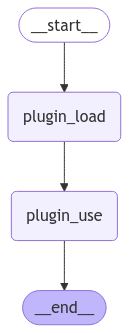

In [10]:
def node_plugin_load(state: State):
    print("node_plugin_load: Loading plugin capabilities...")
    return state

def node_plugin_use(state: State):
    print("node_plugin_use: Using plugin to perform specialized task.")
    return state

builder_plugins = StateGraph(State)
builder_plugins.add_node("plugin_load", node_plugin_load)
builder_plugins.add_node("plugin_use", node_plugin_use)

builder_plugins.add_edge(START, "plugin_load")
builder_plugins.add_edge("plugin_load", "plugin_use")
builder_plugins.add_edge("plugin_use", END)

graph_plugins = builder_plugins.compile()
print("\n=== Example Additional Pattern: Plug-in ===")
display(Image(graph_plugins.get_graph().draw_mermaid_png()))


In [12]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

# LLM Tool Router Pattern Basic

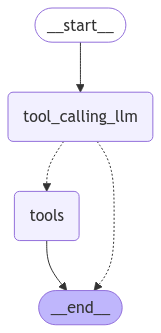

================================ Human Message =================================

Hello world.
================================== Ai Message ==================================

Hello! How can I assist you today?


In [1]:
# Router

## Review

# We built a graph that uses `messages` as state and a chat model with bound tools.
# The graph can:
#  * Return a tool call
#  * Return a natural language response
#
# We think of this as a router: the chat model "routes" between
# direct response or tool call based on user input.
#
# It's a simple example of an agent, where the LLM decides control flow
# either by calling a tool or responding directly.

# ![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

# Let's extend our graph to handle either output:
# (1) Add a node that will call our tool.
# (2) Add a conditional edge that routes to the tool-calling node or ends.



import os
import openai
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Function to load environment variables or raise an error if not found
def get_env_var(var: str):
    value = os.getenv(var)
    if value is None:
        raise ValueError(f"{var} not found in environment variables. Make sure it is set in your .env file.")
    return value

# Load API keys from the environment
langchain_api_key = get_env_var("LANGCHAIN_API_KEY")
langchain_tracing_v2 = get_env_var("LANGCHAIN_TRACING_V2")
openai_api_key = get_env_var("OPENAI_API_KEY")
tavily_api_key = get_env_var("TAVILY_API_KEY")

# We'll create a ChatOpenAI instance
from langchain_openai import ChatOpenAI
gpt4o_chat = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=openai_api_key)
gpt35_chat = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0, openai_api_key=openai_api_key)

# Simple tool: multiply two integers
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# Bind the tool to the LLM
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

# We'll use the built-in `ToolNode` and the `tools_condition` from langgraph.prebuilt
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node that calls the LLM-with-tools. The output can be:
#  - A normal assistant message
#  - A tool call
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))  # The node that executes the tool call

builder.add_edge(START, "tool_calling_llm")

# Use the built-in condition to check if the last message is a tool call
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()

# View the graph as a Mermaid diagram
display(Image(graph.get_graph().draw_mermaid_png()))

# Now let's invoke the graph with a test user message
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="Hello world.")]
messages = graph.invoke({"messages": messages})

# Print the results
for m in messages['messages']:
    m.pretty_print()


# LLM Tool Router Pattern with Weather and Math

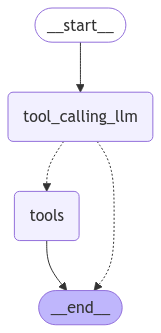


--- Test 1: A normal greeting ---
================================ Human Message =================================

Hello, how are you?
================================== Ai Message ==================================

Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?

--- Test 2: Request the weather in North Bethesda, MD ---
================================ Human Message =================================

What's the weather in North Bethesda, MD right now?
================================== Ai Message ==================================
Tool Calls:
  check_weather (call_lz9UfAWmiDuobKjSubDPIXDT)
 Call ID: call_lz9UfAWmiDuobKjSubDPIXDT
  Args:
    location: North Bethesda, MD
================================= Tool Message =================================
Name: check_weather

It's currently sunny and 75°F in North Bethesda, MD.

--- Test 3: Ask to multiply two numbers ---
================================ Human M

In [14]:
import os
import openai
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

def get_env_var(var: str):
    """Utility for loading environment variables or raising an error if missing."""
    value = os.getenv(var)
    if value is None:
        raise ValueError(f"{var} not found in environment variables. Make sure it is set in your .env file.")
    return value

# Load API keys (adjust variable names to your environment)
langchain_api_key = get_env_var("LANGCHAIN_API_KEY")
langchain_tracing_v2 = get_env_var("LANGCHAIN_TRACING_V2")
openai_api_key = get_env_var("OPENAI_API_KEY")
tavily_api_key = get_env_var("TAVILY_API_KEY")

###############################################################################
# 1) Setup the LLM and Tools
###############################################################################
from langchain_openai import ChatOpenAI

# The first tool remains for demonstration:
def multiply(a: int, b: int) -> int:
    """Multiply two integers."""
    return a * b

# New tool: a simple (mock) weather-check function
# In production, you'd connect this to a real weather API (OpenWeather, etc.)
def check_weather(location: str) -> str:
    """Return a mock string for the weather in the given location."""
    loc_lower = location.strip().lower()
    if "north bethesda" in loc_lower:
        return "It's currently sunny and 75°F in North Bethesda, MD."
    else:
        return f"Sorry, I don't have data for {location}."

# Create an LLM and bind both tools:
#   - multiply
#   - check_weather
llm = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=openai_api_key)
llm_with_tools = llm.bind_tools([multiply, check_weather])

###############################################################################
# 2) Build the Graph
###############################################################################
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# This node calls the LLM + tools. If the LLM decides to call a tool
# (e.g., check_weather or multiply), the output is a tool call message.
# Otherwise, it's a direct response.
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Create a graph with:
#  - A "tool_calling_llm" node
#  - A "tools" node that executes any tool call
#  - A conditional edge to route to "tools" if there's a tool call, or END if not.
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply, check_weather]))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)

# Compile the graph and display the structure
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

###############################################################################
# 3) Run Some Tests
###############################################################################
from langchain_core.messages import HumanMessage

print("\n--- Test 1: A normal greeting ---")
messages = [HumanMessage(content="Hello, how are you?")]
results = graph.invoke({"messages": messages})
for msg in results["messages"]:
    msg.pretty_print()

print("\n--- Test 2: Request the weather in North Bethesda, MD ---")
messages = [HumanMessage(content="What's the weather in North Bethesda, MD right now?")]
results = graph.invoke({"messages": messages})
for msg in results["messages"]:
    msg.pretty_print()

print("\n--- Test 3: Ask to multiply two numbers ---")
messages = [HumanMessage(content="Please multiply 7 and 12.")]
results = graph.invoke({"messages": messages})
for msg in results["messages"]:
    msg.pretty_print()



##  **“ReAct Agent Pattern.”** 

- “**ReAct**” (short for **Reason + Act**) captures the **iterative loop** where the LLM (1) reasons about the current state, (2) calls a tool (acts), (3) observes the output, and repeats.  
- It emphasizes that the agent can keep calling tools in sequence until it’s satisfied and ready to respond with a final answer.  
- This iterative tool-calling loop is the **core** of modern agent frameworks like [LangChain’s ReAct agents](https://react-lm.github.io/) or other “chain-of-thought” style systems.

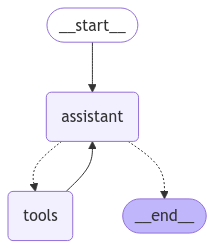

=== Agent Demo with Arithmetic Tools ===

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Then divide the output by 5.
================================== Ai Message ==================================
Tool Calls:
  add (call_FyXN7pt31kHblwyQKFm8Akho)
 Call ID: call_FyXN7pt31kHblwyQKFm8Akho
  Args:
    a: 3
    b: 4
  multiply (call_6RCf24nTajUaIUohmF0pqPAB)
 Call ID: call_6RCf24nTajUaIUohmF0pqPAB
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_6J9BzesJlA9a2FkidnAmKr14)
 Call ID: call_6J9BzesJlA9a2FkidnAmKr14
  Args:
    a: 14
    b: 5
================================= Tool Message =================================
Name: divide

2.8
========

In [15]:
import os
import openai
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

def get_env_var(var: str):
    """Utility to load environment variables or raise if missing."""
    value = os.getenv(var)
    if value is None:
        raise ValueError(f"{var} not found in environment. Ensure it's set in your .env file.")
    return value

# Load API keys from the environment
langchain_api_key = get_env_var("LANGCHAIN_API_KEY")
langchain_tracing_v2 = get_env_var("LANGCHAIN_TRACING_V2")
langchain_endpoint = get_env_var("LANGCHAIN_ENDPOINT")
openai_api_key = get_env_var("OPENAI_API_KEY")
tavily_api_key = get_env_var("TAVILY_API_KEY")

# We'll designate a project for tracing, if desired
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

###############################################################################
# 1) Setup the LLM
###############################################################################
from langchain_openai import ChatOpenAI

gpt4o_chat = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=openai_api_key)
gpt35_chat = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0, openai_api_key=openai_api_key)

# Tools: add, multiply, divide
def add(a: int, b: int) -> int:
    """Add two integers a and b."""
    return a + b

def multiply(a: int, b: int) -> int:
    """Multiply two integers a and b."""
    return a * b

def divide(a: int, b: int) -> float:
    """Divide a by b."""
    return a / b

tools = [add, multiply, divide]

# Create an LLM instance and bind the tools
llm = ChatOpenAI(model="gpt-4o", openai_api_key=openai_api_key)
llm_with_tools = llm.bind_tools(tools)

###############################################################################
# 2) Define Node Functions
###############################################################################
"""
We use `MessagesState` to keep track of the conversation.
We'll have an 'assistant' node that calls the LLM with tools,
and a 'tools' node that executes any tool requests from the LLM.
"""

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState

# A system message that frames the overall instruction:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
    """
    This node invokes the LLM (with bound tools). The output can be:
    - A normal assistant text message
    - A tool call message
    """
    # We combine the system message with the user's messages
    result = llm_with_tools.invoke([sys_msg] + state["messages"])
    return {"messages": [result]}

###############################################################################
# 3) Build the Graph (Agent) with a ReAct-like loop
###############################################################################
"""
We create:
- an 'assistant' node (where the LLM decides what to do),
- a 'tools' node that executes a tool call if the assistant made one,
- a conditional edge (tools_condition) that looks at the assistant's
  last output. If it's a tool call => go to 'tools'; otherwise => END.
- an edge from 'tools' back to 'assistant' for iterative calls.
"""

from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Start -> assistant
builder.add_edge(START, "assistant")

# assistant -> [tools or END], depending on whether the model made a tool call
builder.add_conditional_edges("assistant", tools_condition)

# tools -> assistant (loop back after tool results are appended)
builder.add_edge("tools", "assistant")

# Compile
react_graph = builder.compile()

# Visualize
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

###############################################################################
# 4) Run the Agent
###############################################################################
"""
We send a single user request: 
'Add 3 and 4. Multiply the output by 2. Divide the output by 5.'

The model may:
1) call add(3,4),
2) incorporate result, 
3) call multiply(...) with that result, 
4) incorporate result,
5) call divide(...) with that result, 
6) finalize a response,
or deviate as it sees fit. 
"""

print("=== Agent Demo with Arithmetic Tools ===\n")

messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Then divide the output by 5.")]
result = react_graph.invoke({"messages": messages})

for msg in result['messages']:
    msg.pretty_print()

print("\n--- Done! ---")

###############################################################################
# (Optional) Check LangSmith for traces if you have it configured
###############################################################################



We can look at traces in LangSmith. [Click here to visit Smith LangChain](https://smith.langchain.com)

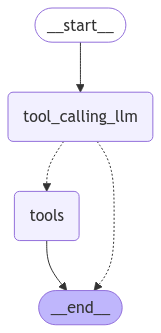


--- Test 1: A normal greeting ---
================================ Human Message =================================

Hello, how are you?
================================== Ai Message ==================================

Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?

--- Test 2: Request the weather in North Bethesda, MD ---
================================ Human Message =================================

What's the weather in North Bethesda, MD right now?
================================== Ai Message ==================================
Tool Calls:
  check_weather (call_OOjaBdANL9wC3POsy3OdUhat)
 Call ID: call_OOjaBdANL9wC3POsy3OdUhat
  Args:
    location: North Bethesda, MD
================================= Tool Message =================================
Name: check_weather

It's currently 24°F in North Bethesda, MD.

--- Test 3: Ask to multiply two numbers ---
================================ Human Message ===

In [16]:
import os
import openai
import requests
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

def get_env_var(var: str):
    """Utility for loading environment variables or raising an error if missing."""
    value = os.getenv(var)
    if value is None:
        raise ValueError(f"{var} not found in environment variables. Make sure it is set in your .env file.")
    return value

# Load API keys (adjust variable names to your environment)
langchain_api_key = get_env_var("LANGCHAIN_API_KEY")
langchain_tracing_v2 = get_env_var("LANGCHAIN_TRACING_V2")
openai_api_key = get_env_var("OPENAI_API_KEY")
tavily_api_key = get_env_var("TAVILY_API_KEY")

###############################################################################
# 1) Setup the LLM and Tools
###############################################################################
from langchain_openai import ChatOpenAI

# First tool remains for demonstration:
def multiply(a: int, b: int) -> int:
    """Multiply two integers."""
    return a * b

# New tool: calls wttr.in to get real weather data
def check_weather(location: str) -> str:
    """
    Return current weather for the given location using wttr.in in Fahrenheit.
    Example response: "It's currently 75°F in North Bethesda, MD."
    """
    try:
        # Format the location so wttr.in can interpret it
        loc = location.strip().replace(" ", "+")  # e.g. "North+Bethesda,+MD"
        url = f"https://wttr.in/{loc}?format=j1"
        resp = requests.get(url, timeout=10)
        if resp.status_code == 200:
            data = resp.json()
            current_temp_f = data["current_condition"][0]["temp_F"]
            return f"It's currently {current_temp_f}°F in {location}."
        else:
            return f"Sorry, I couldn't fetch the weather (HTTP {resp.status_code})."
    except Exception as e:
        return f"Error calling wttr.in: {e}"

# Create an LLM and bind both tools:
#   - multiply
#   - check_weather
llm = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=openai_api_key)
llm_with_tools = llm.bind_tools([multiply, check_weather])

###############################################################################
# 2) Build the Graph
###############################################################################
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# This node calls the LLM + tools. If the LLM decides to call a tool
# (e.g., check_weather or multiply), the output is a tool call message.
# Otherwise, it's a direct response.
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Create a graph with:
#  - A "tool_calling_llm" node
#  - A "tools" node that executes any tool call
#  - A conditional edge to route to "tools" if there's a tool call, or END if not.
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply, check_weather]))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)

# Compile the graph and display the structure
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

###############################################################################
# 3) Run Some Tests
###############################################################################
from langchain_core.messages import HumanMessage

print("\n--- Test 1: A normal greeting ---")
messages = [HumanMessage(content="Hello, how are you?")]
results = graph.invoke({"messages": messages})
for msg in results["messages"]:
    msg.pretty_print()

print("\n--- Test 2: Request the weather in North Bethesda, MD ---")
messages = [HumanMessage(content="What's the weather in North Bethesda, MD right now?")]
results = graph.invoke({"messages": messages})
for msg in results["messages"]:
    msg.pretty_print()

print("\n--- Test 3: Ask to multiply two numbers ---")
messages = [HumanMessage(content="Please multiply 7 and 12.")]
results = graph.invoke({"messages": messages})
for msg in results["messages"]:
    msg.pretty_print()


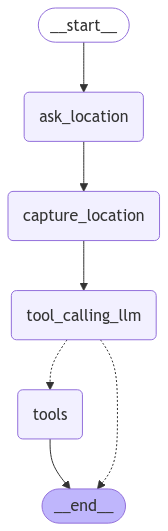


--- Demo: ask_location -> capture_location -> tool_calling_llm -> tools/END ---
[ask_location] Prompt user for location.
[capture_location] Captured location: North Bethesda, MD.
[tool_calling_llm] Invoking LLM with tools.

--- Final Messages ---
================================ Human Message =================================

I'd like the weather, please.
================================ Human Message =================================

North Bethesda, MD.
================================== Ai Message ==================================

Which location would you like the weather information for?
================================== Ai Message ==================================
Tool Calls:
  check_weather (call_M8nzWATrqcIJd0WCu9r9XWRr)
 Call ID: call_M8nzWATrqcIJd0WCu9r9XWRr
  Args:
    location: North Bethesda, MD
================================= Tool Message =================================
Name: check_weather

It's currently 24°F in North Bethesda, MD.


In [19]:
import os
import openai
import requests
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

def get_env_var(var: str):
    """Utility for loading environment variables or raising an error if missing."""
    value = os.getenv(var)
    if value is None:
        raise ValueError(f"{var} not found in environment variables. Make sure it is set in your .env file.")
    return value

# Load API keys (adjust variable names to your environment)
langchain_api_key = get_env_var("LANGCHAIN_API_KEY")
langchain_tracing_v2 = get_env_var("LANGCHAIN_TRACING_V2")
openai_api_key = get_env_var("OPENAI_API_KEY")
tavily_api_key = get_env_var("TAVILY_API_KEY")

###############################################################################
# 1) Setup the LLM and Tools
###############################################################################
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply two integers."""
    return a * b

def check_weather(location: str) -> str:
    """
    Return current weather for the given location using wttr.in in Fahrenheit.
    Example response: "It's currently 75°F in North Bethesda, MD."
    """
    try:
        loc = location.strip().replace(" ", "+")  # e.g. "North+Bethesda,+MD"
        url = f"https://wttr.in/{loc}?format=j1"
        resp = requests.get(url, timeout=10)
        if resp.status_code == 200:
            data = resp.json()
            current_temp_f = data["current_condition"][0]["temp_F"]
            return f"It's currently {current_temp_f}°F in {location}."
        else:
            return f"Sorry, I couldn't fetch the weather (HTTP {resp.status_code})."
    except Exception as e:
        return f"Error calling wttr.in: {e}"

# Create an LLM and bind both tools
llm = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=openai_api_key)
llm_with_tools = llm.bind_tools([multiply, check_weather])

###############################################################################
# 2) Define Our Nodes
###############################################################################
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import MessagesState

def ask_location(state: MessagesState):
    """
    Append an AIMessage that asks the user for a location.
    In a real chat UI, we'd wait for the user's next input.
    """
    prompt_msg = AIMessage(content="Which location would you like the weather information for?")
    state["messages"].append(prompt_msg)
    print("[ask_location] Prompt user for location.")
    return {"messages": state["messages"]}

def capture_location(state: MessagesState):
    """
    Look at the last user message after ask_location, parse it as the location,
    and store it in state["location"]. If the user hasn't provided a location,
    we'll store None.
    """
    # We'll assume the last message in the conversation is from the user:
    last_msg = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            last_msg = msg
            break
    if last_msg:
        user_location = last_msg.content.strip()
        state["location"] = user_location
        print(f"[capture_location] Captured location: {user_location}")
    else:
        state["location"] = None
        print("[capture_location] No user location found!")
    return {"messages": state["messages"]}

def tool_calling_llm(state: MessagesState):
    """
    Invokes the LLM-with-tools. The LLM can decide to respond or call a tool.
    We'll pass the location to the LLM in the conversation if we want the model
    to see it as well.
    """
    location = state.get("location", None)
    if location:
        # Optionally, we add a message to remind the LLM of the location
        # so it might do something like `check_weather(location)`.
        info_msg = AIMessage(content=f"User wants the weather for: {location}")
        state["messages"].append(info_msg)

    print("[tool_calling_llm] Invoking LLM with tools.")
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

###############################################################################
# 3) Build the Graph
###############################################################################
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("ask_location", ask_location)
builder.add_node("capture_location", capture_location)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply, check_weather]))

# Flow:
#  1) ask_location -> prompts user
#  2) capture_location -> stores user's location in state
#  3) tool_calling_llm -> LLM decides to call a tool or not
#  4) if tool call => tools, else => end
builder.add_edge(START, "ask_location")
builder.add_edge("ask_location", "capture_location")
builder.add_edge("capture_location", "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

###############################################################################
# 4) Demonstration
###############################################################################
print("\n--- Demo: ask_location -> capture_location -> tool_calling_llm -> tools/END ---")

# Suppose the user initially says "I'd like the weather, please."
# Then, after being asked, they respond with "North Bethesda, MD."
# We'll simulate that as two user messages in the conversation array:
initial_messages = [
    HumanMessage(content="I'd like the weather, please."),
    HumanMessage(content="North Bethesda, MD.")
]

result = graph.invoke({"messages": initial_messages})
print("\n--- Final Messages ---")
for msg in result["messages"]:
    msg.pretty_print()


In [20]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph requests

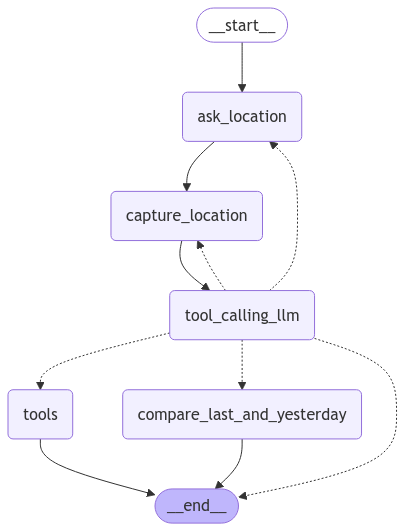


=== Demo #1: Check Weather (Stores to File) ===

--- Final Messages #1 ---
================================ Human Message =================================

I'd like the weather, please.
================================ Human Message =================================

North Bethesda, MD.
================================== Ai Message ==================================

Which location would you like the weather for?
================================== Ai Message ==================================
Tool Calls:
  check_weather (call_RrypCRLOZS0XIjmQkAuoUJf0)
 Call ID: call_RrypCRLOZS0XIjmQkAuoUJf0
  Args:
    location: North Bethesda, MD
================================= Tool Message =================================
Name: check_weather

It's currently 30.0°F in North Bethesda, MD.

=== Demo #2: Compare Last Hour w/ Yesterday ===

--- Final Messages #2 ---
================================ Human Message =================================

Compare last hour with yesterday.
====================

In [3]:
import os
import openai
import requests
import json
from datetime import datetime, timedelta
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

##############################################################################
# 1) Environment & Basic Setup
##############################################################################
load_dotenv()

def get_env_var(var: str):
    """Utility to fetch environment variables or raise an error."""
    value = os.getenv(var)
    if value is None:
        raise ValueError(f"{var} not found in environment variables. Check .env.")
    return value

langchain_api_key = get_env_var("LANGCHAIN_API_KEY")
langchain_tracing_v2 = get_env_var("LANGCHAIN_TRACING_V2")
openai_api_key = get_env_var("OPENAI_API_KEY")
tavily_api_key = get_env_var("TAVILY_API_KEY")

##############################################################################
# 2) File-Based Hourly Weather Memory
##############################################################################
class FileHourlyWeatherMemory:
    """
    A memory that stores hourly weather data in a JSON file, so data persists
    across runs. Key: 'YYYY-MM-DD HH' => (location, temp_f)
    """
    def __init__(self, file_path="weather_memory.json"):
        self.file_path = file_path
        self.hourly_log = self._load_from_file()

    def store_temperature(self, location: str, temp_f: float):
        """
        Store a temperature reading keyed by the current hour, then persist to file.
        """
        now = datetime.now().strftime('%Y-%m-%d %H')
        self.hourly_log[now] = (location, temp_f)
        self._save_to_file()

    def get_last_logged_temperature(self):
        """
        Return the most recent hour's data, or None if empty.
        """
        if not self.hourly_log:
            return None
        sorted_keys = sorted(self.hourly_log.keys())
        latest_hour = sorted_keys[-1]
        loc, temp = self.hourly_log[latest_hour]
        return (latest_hour, loc, temp)

    def get_last_and_yesterday(self):
        """
        Get the last hour's log and the log from exactly 24 hours prior,
        if it exists. Returns a dict:
            {
              "latest_hour": (hour_str, location, temp),
              "yesterday_hour": (hour_str, location, temp) or None
            }
        or None if no data at all.
        """
        if not self.hourly_log:
            return None

        # 1) Sort hour-keys and pick the most recent
        sorted_keys = sorted(self.hourly_log.keys())
        latest_hour_str = sorted_keys[-1]
        loc, temp = self.hourly_log[latest_hour_str]

        # 2) Parse that hour, subtract 24 hours
        dt_latest = datetime.strptime(latest_hour_str, '%Y-%m-%d %H')
        dt_yesterday = dt_latest - timedelta(hours=24)
        yesterday_key = dt_yesterday.strftime('%Y-%m-%d %H')

        # 3) Attempt to retrieve the "yesterday" reading at the same hour
        if yesterday_key in self.hourly_log:
            y_loc, y_temp = self.hourly_log[yesterday_key]
            y_data = (yesterday_key, y_loc, y_temp)
        else:
            y_data = None

        return {
            "latest_hour": (latest_hour_str, loc, temp),
            "yesterday_hour": y_data
        }

    def _save_to_file(self):
        with open(self.file_path, "w", encoding="utf-8") as f:
            json.dump(self.hourly_log, f)

    def _load_from_file(self):
        if not os.path.exists(self.file_path):
            return {}
        with open(self.file_path, "r", encoding="utf-8") as f:
            return json.load(f)

weather_memory = FileHourlyWeatherMemory()

##############################################################################
# 3) Tools (with docstrings) & LLM
##############################################################################
def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): First integer
        b (int): Second integer

    Returns:
        int: The product of a and b
    """
    return a * b

def check_weather(location: str) -> str:
    """
    Fetch real-time weather from wttr.in in Fahrenheit, 
    then store the result in a file-based memory.

    Args:
        location (str): The location to fetch weather for

    Returns:
        str: A message describing the temperature or an error
    """
    try:
        loc = location.strip().replace(" ", "+")
        url = f"https://wttr.in/{loc}?format=j1"
        resp = requests.get(url, timeout=10)
        if resp.status_code == 200:
            data = resp.json()
            current_temp_f = float(data["current_condition"][0]["temp_F"])
            weather_memory.store_temperature(location, current_temp_f)
            return f"It's currently {current_temp_f}°F in {location}."
        else:
            return f"Sorry, I couldn't fetch the weather (HTTP {resp.status_code})."
    except Exception as e:
        return f"Error calling wttr.in: {e}"

llm = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=openai_api_key)
llm_with_tools = llm.bind_tools([multiply, check_weather])

##############################################################################
# 4) Define Nodes
##############################################################################
from langchain_core.messages import HumanMessage, AIMessage

def ask_location(state: MessagesState):
    state["messages"].append(AIMessage(content="Which location would you like the weather for?"))
    return {"messages": state["messages"]}

def capture_location(state: MessagesState):
    """Captures the user's last message as location."""
    last_user_msg = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            last_user_msg = msg.content.strip()
            break
    state["location"] = last_user_msg
    return {"messages": state["messages"]}

def tool_calling_llm(state: MessagesState):
    """The LLM decides to call a tool or just respond."""
    location = state.get("location")
    if location:
        state["messages"].append(AIMessage(content=f"User wants weather for {location}."))

    return {"messages": [llm_with_tools.invoke(state["messages"])]}

def compare_last_and_yesterday(state: MessagesState):
    """
    A node that compares the last hour temperature vs. 24 hours prior,
    then appends an AIMessage summarizing the result.
    """
    data = weather_memory.get_last_and_yesterday()
    if data is None:
        # No data at all
        msg = "No weather data has been logged yet. Please check weather first."
    else:
        latest = data["latest_hour"]
        y_data = data["yesterday_hour"]
        if y_data is None:
            # No entry from 24 hours before
            hour_str, loc, temp = latest
            msg = (f"As of {hour_str}, the last logged temperature was {temp:.1f}°F in {loc}. "
                   "No data from exactly 24 hours ago.")
        else:
            # We have both
            hour_str, loc, temp = latest
            y_hour_str, y_loc, y_temp = y_data
            msg = (f"As of {hour_str}, the temperature was {temp:.1f}°F in {loc}. "
                   f"Exactly 24 hours earlier (at {y_hour_str}), it was {y_temp:.1f}°F in {y_loc}.")

    state["messages"].append(AIMessage(content=msg))
    return {"messages": state["messages"]}

##############################################################################
# 5) Decide Routing (Condition)
##############################################################################
def recall_or_compare_condition(state: MessagesState):
    """
    If user says "compare last hour with yesterday" => go to compare_last_and_yesterday
    Else if the LLM generated a tool call => go to "tools" node
    Otherwise => end
    """
    # 1) Check user message for "compare last"
    last_user_text = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            last_user_text = msg.content.lower()
            break
    if last_user_text and "compare last" in last_user_text:
        return ["compare_last_and_yesterday"]
    
    # 2) Fallback to normal "tools_condition"
    from langgraph.prebuilt import tools_condition
    return tools_condition(state)

##############################################################################
# 6) Build the Graph
##############################################################################
builder = StateGraph(MessagesState)
builder.add_node("ask_location", ask_location)
builder.add_node("capture_location", capture_location)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply, check_weather]))
builder.add_node("compare_last_and_yesterday", compare_last_and_yesterday)

# Flow:
builder.add_edge(START, "ask_location")
builder.add_edge("ask_location", "capture_location")
builder.add_edge("capture_location", "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", recall_or_compare_condition)
# If LLM calls a tool => "tools", else => "end"
builder.add_edge("tools", END)
# If user says "compare last" => "compare_last_and_yesterday"
builder.add_edge("compare_last_and_yesterday", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

##############################################################################
# 7) Demo 1: Check Weather
##############################################################################
print("\n=== Demo #1: Check Weather (Stores to File) ===")
messages1 = [
    HumanMessage(content="I'd like the weather, please."),
    HumanMessage(content="North Bethesda, MD.")
]
result1 = graph.invoke({"messages": messages1})
print("\n--- Final Messages #1 ---")
for msg in result1["messages"]:
    msg.pretty_print()

##############################################################################
# 8) Demo 2: Compare Last Hour vs. Yesterday
##############################################################################
print("\n=== Demo #2: Compare Last Hour w/ Yesterday ===")
messages2 = [
    HumanMessage(content="Compare last hour with yesterday.")
]
result2 = graph.invoke({"messages": messages2})
print("\n--- Final Messages #2 ---")
for msg in result2["messages"]:
    msg.pretty_print()

##############################################################################
# 9) Inspect the JSON Log
##############################################################################
print("\n=== Memory Log Contents ===")
print(weather_memory.hourly_log)


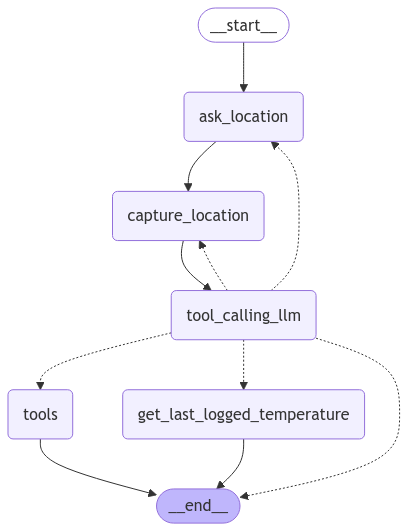


=== Demo #1: Check Weather (Stores to File) ===

--- Final Messages #1 ---
================================ Human Message =================================

I'd like the weather, please.
================================ Human Message =================================

North Bethesda, MD.
================================== Ai Message ==================================

Which location would you like the weather for?

=== Demo #2: Retrieve Last Logged Temperature ===

--- Final Messages #2 ---
================================ Human Message =================================

What was the last temperature logged?
================================== Ai Message ==================================

Which location would you like the weather for?
================================== Ai Message ==================================

The most recent logged temperature was 30.0°F in North Bethesda, MD at 2025-02-21 14.

=== Memory Log Contents ===
{'2025-02-18 13': ['North Bethesda, MD', 24.0], '2025-02-

In [4]:
import os
import openai
import requests
import json
from datetime import datetime
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

##############################################################################
# 1) Environment & Basic Setup
##############################################################################
load_dotenv()

def get_env_var(var: str):
    """Utility to fetch environment variables or raise an error."""
    value = os.getenv(var)
    if value is None:
        raise ValueError(f"{var} not found in environment variables. Check .env.")
    return value

langchain_api_key = get_env_var("LANGCHAIN_API_KEY")
openai_api_key = get_env_var("OPENAI_API_KEY")

##############################################################################
# 2) File-Based Hourly Weather Memory
##############################################################################
class FileHourlyWeatherMemory:
    """Persistent weather memory storing hourly weather data in a JSON file."""

    def __init__(self, file_path="weather_memory.json"):
        self.file_path = file_path
        self.hourly_log = self._load_from_file()

    def store_temperature(self, location: str, temp_f: float):
        """Stores the temperature reading for the current hour."""
        now = datetime.now().strftime('%Y-%m-%d %H')
        self.hourly_log[now] = (location, temp_f)
        self._save_to_file()

    def get_last_logged_temperature(self):
        """Returns the most recent logged temperature, or None if no data exists."""
        if not self.hourly_log:
            return None
        sorted_keys = sorted(self.hourly_log.keys())
        latest_hour = sorted_keys[-1]
        loc, temp = self.hourly_log[latest_hour]
        return (latest_hour, loc, temp)

    def _save_to_file(self):
        with open(self.file_path, "w", encoding="utf-8") as f:
            json.dump(self.hourly_log, f)

    def _load_from_file(self):
        if not os.path.exists(self.file_path):
            return {}
        with open(self.file_path, "r", encoding="utf-8") as f:
            return json.load(f)

weather_memory = FileHourlyWeatherMemory()

##############################################################################
# 3) Weather API & Tools
##############################################################################
def check_weather(location: str) -> str:
    """Fetches real-time weather from wttr.in and logs it in memory."""
    try:
        loc = location.strip().replace(" ", "+")
        url = f"https://wttr.in/{loc}?format=j1"
        resp = requests.get(url, timeout=10)
        if resp.status_code == 200:
            data = resp.json()
            current_temp_f = float(data["current_condition"][0]["temp_F"])
            weather_memory.store_temperature(location, current_temp_f)
            return f"It's currently {current_temp_f}°F in {location}."
        else:
            return f"Sorry, I couldn't fetch the weather (HTTP {resp.status_code})."
    except Exception as e:
        return f"Error calling wttr.in: {e}"

llm = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=openai_api_key)
llm_with_tools = llm.bind_tools([check_weather])

##############################################################################
# 4) Define Nodes
##############################################################################
def ask_location(state: MessagesState):
    """Asks for a location only if not already provided."""
    if "location" not in state or not state["location"]:
        state["messages"].append(AIMessage(content="Which location would you like the weather for?"))
    return {"messages": state["messages"]}

def capture_location(state: MessagesState):
    """Captures the user's most recent message as the location."""
    last_user_msg = next(
        (msg.content.strip() for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)), None
    )
    state["location"] = last_user_msg
    return {"messages": state["messages"]}

def tool_calling_llm(state: MessagesState):
    """Decides whether to call a tool or respond directly."""
    location = state.get("location")
    if location:
        return {"messages": [llm_with_tools.invoke(state["messages"])]}
    return {"messages": state["messages"]}

def get_last_logged_temperature(state: MessagesState):
    """Retrieves the most recent logged temperature and appends it to the conversation."""
    latest = weather_memory.get_last_logged_temperature()
    if latest is None:
        msg = "No weather data has been logged yet. Please check weather first."
    else:
        hour_str, loc, temp = latest
        msg = f"The most recent logged temperature was {temp:.1f}°F in {loc} at {hour_str}."
    
    state["messages"].append(AIMessage(content=msg))
    return {"messages": state["messages"]}

##############################################################################
# 5) Routing Logic
##############################################################################
def decide_next_step(state: MessagesState):
    """
    Determines whether to check weather, recall the last temperature,
    or proceed to tool execution.
    """
    last_user_text = next(
        (msg.content.lower() for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)), ""
    )

    if "last temperature" in last_user_text:
        return ["get_last_logged_temperature"]

    from langgraph.prebuilt import tools_condition
    return tools_condition(state)

##############################################################################
# 6) Build the Graph
##############################################################################
builder = StateGraph(MessagesState)
builder.add_node("ask_location", ask_location)
builder.add_node("capture_location", capture_location)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([check_weather]))
builder.add_node("get_last_logged_temperature", get_last_logged_temperature)

# Define Flow
builder.add_edge(START, "ask_location")
builder.add_edge("ask_location", "capture_location")
builder.add_edge("capture_location", "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", decide_next_step)
builder.add_edge("tools", END)
builder.add_edge("get_last_logged_temperature", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

##############################################################################
# 7) Demo 1: Check Weather
##############################################################################
print("\n=== Demo #1: Check Weather (Stores to File) ===")
messages1 = [
    HumanMessage(content="I'd like the weather, please."),
    HumanMessage(content="North Bethesda, MD.")
]
result1 = graph.invoke({"messages": messages1})
print("\n--- Final Messages #1 ---")
for msg in result1["messages"]:
    msg.pretty_print()

##############################################################################
# 8) Demo 2: Get Last Logged Temperature
##############################################################################
print("\n=== Demo #2: Retrieve Last Logged Temperature ===")
messages2 = [
    HumanMessage(content="What was the last temperature logged?")
]
result2 = graph.invoke({"messages": messages2})
print("\n--- Final Messages #2 ---")
for msg in result2["messages"]:
    msg.pretty_print()

##############################################################################
# 9) Inspect the JSON Log
##############################################################################
print("\n=== Memory Log Contents ===")
print(weather_memory.hourly_log)


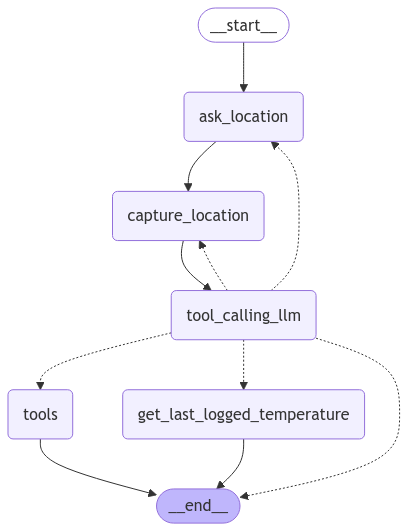


=== Demo #1: Check Weather ===

--- Final Messages #1 ---
================================ Human Message =================================

I'd like the weather, please.
================================ Human Message =================================

North Bethesda, MD.
================================== Ai Message ==================================

Which location would you like the weather for?

=== Demo #2: Retrieve Last Logged Temperature ===

--- Final Messages #2 ---
================================ Human Message =================================

What was the last temperature logged?
================================== Ai Message ==================================

Which location would you like the weather for?
================================== Ai Message ==================================

The most recent logged temperature was 30.0°F in North Bethesda, MD at 2025-02-21 14.

=== Memory Log Contents ===
{'2025-02-18 13': ['North Bethesda, MD', 24.0], '2025-02-18 15': ['North B

In [5]:
import os
import requests
import json
from datetime import datetime
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

##############################################################################
# 1) Environment & Basic Setup
##############################################################################
load_dotenv()

def get_env_var(var: str):
    """Fetches environment variables or raises an error if missing."""
    value = os.getenv(var)
    if value is None:
        raise ValueError(f"{var} not found in environment variables. Check .env.")
    return value

openai_api_key = get_env_var("OPENAI_API_KEY")

##############################################################################
# 2) File-Based Hourly Weather Memory
##############################################################################
class FileHourlyWeatherMemory:
    """Persistent weather memory storing hourly weather data in a JSON file."""

    def __init__(self, file_path="weather_memory.json"):
        self.file_path = file_path
        self.hourly_log = self._load_from_file()

    def store_temperature(self, location: str, temp_f: float):
        """Stores temperature reading for the current hour."""
        now = datetime.now().strftime('%Y-%m-%d %H')
        self.hourly_log[now] = (location, temp_f)
        self._save_to_file()

    def get_last_logged_temperature(self):
        """Returns the most recent logged temperature, or None if no data exists."""
        if not self.hourly_log:
            return None
        latest_hour = max(self.hourly_log.keys())
        loc, temp = self.hourly_log[latest_hour]
        return latest_hour, loc, temp

    def _save_to_file(self):
        with open(self.file_path, "w", encoding="utf-8") as f:
            json.dump(self.hourly_log, f)

    def _load_from_file(self):
        if not os.path.exists(self.file_path):
            return {}
        with open(self.file_path, "r", encoding="utf-8") as f:
            return json.load(f)

weather_memory = FileHourlyWeatherMemory()

##############################################################################
# 3) Weather API & Tools
##############################################################################
def check_weather(location: str) -> str:
    """Fetches real-time weather from wttr.in and logs it in memory."""
    try:
        loc = location.strip().replace(" ", "+")
        url = f"https://wttr.in/{loc}?format=j1"
        resp = requests.get(url, timeout=10)
        if resp.status_code == 200:
            data = resp.json()
            current_temp_f = float(data["current_condition"][0]["temp_F"])
            weather_memory.store_temperature(location, current_temp_f)
            return f"It's currently {current_temp_f}°F in {location}."
        return f"Sorry, I couldn't fetch the weather (HTTP {resp.status_code})."
    except Exception as e:
        return f"Error calling wttr.in: {e}"

llm = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=openai_api_key)
llm_with_tools = llm.bind_tools([check_weather])

##############################################################################
# 4) Define Nodes
##############################################################################
def ask_location(state: MessagesState):
    """Asks for a location only if not already provided."""
    if not state.get("location"):
        state["messages"].append(AIMessage(content="Which location would you like the weather for?"))
    return {"messages": state["messages"]}

def capture_location(state: MessagesState):
    """Captures the user's most recent message as the location."""
    last_user_msg = next(
        (msg.content.strip() for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)), None
    )
    state["location"] = last_user_msg
    return {"messages": state["messages"]}

def tool_calling_llm(state: MessagesState):
    """Calls the weather API if a location is provided."""
    location = state.get("location")
    if location:
        return {"messages": [llm_with_tools.invoke(state["messages"])]}
    return {"messages": state["messages"]}

def get_last_logged_temperature(state: MessagesState):
    """Retrieves the most recent logged temperature and appends it to the conversation."""
    latest = weather_memory.get_last_logged_temperature()
    if latest:
        hour_str, loc, temp = latest
        msg = f"The most recent logged temperature was {temp:.1f}°F in {loc} at {hour_str}."
    else:
        msg = "No weather data has been logged yet. Please check the weather first."
    
    state["messages"].append(AIMessage(content=msg))
    return {"messages": state["messages"]}

##############################################################################
# 5) Routing Logic
##############################################################################
def decide_next_step(state: MessagesState):
    """Determines whether to check weather, recall last temp, or proceed to tool execution."""
    last_user_text = next(
        (msg.content.lower() for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)), ""
    )

    if "last temperature" in last_user_text:
        return ["get_last_logged_temperature"]

    from langgraph.prebuilt import tools_condition
    return tools_condition(state)

##############################################################################
# 6) Build the Graph
##############################################################################
builder = StateGraph(MessagesState)
builder.add_node("ask_location", ask_location)
builder.add_node("capture_location", capture_location)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([check_weather]))
builder.add_node("get_last_logged_temperature", get_last_logged_temperature)

# Define Flow
builder.add_edge(START, "ask_location")
builder.add_edge("ask_location", "capture_location")
builder.add_edge("capture_location", "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", decide_next_step)
builder.add_edge("tools", END)
builder.add_edge("get_last_logged_temperature", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

##############################################################################
# 7) Demo 1: Check Weather
##############################################################################
print("\n=== Demo #1: Check Weather ===")
messages1 = [
    HumanMessage(content="I'd like the weather, please."),
    HumanMessage(content="North Bethesda, MD.")
]
result1 = graph.invoke({"messages": messages1})
print("\n--- Final Messages #1 ---")
for msg in result1["messages"]:
    msg.pretty_print()

##############################################################################
# 8) Demo 2: Retrieve Last Logged Temperature
##############################################################################
print("\n=== Demo #2: Retrieve Last Logged Temperature ===")
messages2 = [
    HumanMessage(content="What was the last temperature logged?")
]
result2 = graph.invoke({"messages": messages2})
print("\n--- Final Messages #2 ---")
for msg in result2["messages"]:
    msg.pretty_print()

##############################################################################
# 9) Inspect the JSON Log
##############################################################################
print("\n=== Memory Log Contents ===")
print(weather_memory.hourly_log)


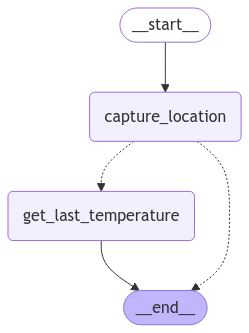


=== Demo #1: Check Weather ===

--- Final Messages #1 ---
================================ Human Message =================================

I would like the weather for North Bethesda, MD.
================================== Ai Message ==================================

It's currently 30.0°F in North Bethesda, MD.

=== Demo #2: Retrieve Last Recorded Temperature ===

--- Final Messages #2 ---
================================ Human Message =================================

What was the last recorded temperature?
================================== Ai Message ==================================

The last recorded temperature was 30.0°F in North Bethesda, MD at 2025-02-21 14.

=== Memory Log Contents ===
{
  "2025-02-18 13": [
    "North Bethesda, MD",
    24.0
  ],
  "2025-02-18 15": [
    "North Bethesda, MD",
    24.0
  ],
  "2025-02-18 18": [
    "North Bethesda, MD",
    29.0
  ],
  "2025-02-19 07": [
    "North Bethesda, MD",
    15.0
  ],
  "2025-02-21 10": [
    "North Bethesda, M

In [13]:
import os
import requests
import json
from datetime import datetime
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

##############################################################################
# 1) Environment & Basic Setup
##############################################################################
load_dotenv()

def get_env_var(var: str):
    """Fetches environment variables or raises an error if missing."""
    value = os.getenv(var)
    if value is None:
        raise ValueError(f"{var} not found in environment variables. Check .env.")
    return value

openai_api_key = get_env_var("OPENAI_API_KEY")

##############################################################################
# 2) File-Based Hourly Weather Memory
##############################################################################
class FileHourlyWeatherMemory:
    """Persistent weather memory storing hourly weather data in a JSON file."""

    def __init__(self, file_path="weather_memory.json"):
        self.file_path = file_path
        self.hourly_log = self._load_from_file()

    def store_temperature(self, location: str, temp_f: float):
        """Stores temperature reading for the current hour."""
        now = datetime.now().strftime('%Y-%m-%d %H')
        cleaned_location = location.strip().replace(".", "")  # Clean up formatting
        self.hourly_log[now] = (cleaned_location, temp_f)
        self._save_to_file()

    def get_last_logged_temperature(self):
        """Returns the most recent logged temperature, or None if no data exists."""
        if not self.hourly_log:
            return None
        latest_hour = max(self.hourly_log.keys())
        loc, temp = self.hourly_log[latest_hour]
        return latest_hour, loc, temp

    def _save_to_file(self):
        with open(self.file_path, "w", encoding="utf-8") as f:
            json.dump(self.hourly_log, f)

    def _load_from_file(self):
        if not os.path.exists(self.file_path):
            return {}
        with open(self.file_path, "r", encoding="utf-8") as f:
            return json.load(f)

weather_memory = FileHourlyWeatherMemory()

##############################################################################
# 3) Weather API & Tools
##############################################################################
def check_weather(location: str) -> str:
    """Fetches real-time weather from wttr.in and logs it in memory. Silently ignores errors."""
    try:
        loc = location.strip().replace(" ", "+")
        url = f"https://wttr.in/{loc}?format=j1"
        resp = requests.get(url, timeout=10)

        if resp.status_code == 200:
            data = resp.json()
            current_temp_f = float(data["current_condition"][0]["temp_F"])
            weather_memory.store_temperature(location, current_temp_f)
            return f"It's currently {current_temp_f}°F in {location}."

        # Silently fail on error (no error message shown)
        return ""

    except Exception:
        return ""

llm = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=openai_api_key)
llm_with_tools = llm.bind_tools([check_weather])

##############################################################################
# 4) Define Nodes
##############################################################################
def capture_location(state: MessagesState):
    """Captures the user's location request and triggers weather fetch."""
    last_user_msg = next(
        (msg.content.strip() for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)), None
    )

    location = last_user_msg.replace("I would like the weather for ", "").strip()
    location = location.replace(".", "")  # Clean punctuation
    state["location"] = location

    weather_response = check_weather(state["location"])
    if weather_response:  # Only add a message if the weather API worked
        state["messages"].append(AIMessage(content=weather_response))

    return {"messages": state["messages"]}

def get_last_temperature(state: MessagesState):
    """Retrieves the last recorded temperature from stored logs."""
    last_logged = weather_memory.get_last_logged_temperature()
    
    if last_logged:
        last_hour, loc, temp = last_logged
        msg = f"The last recorded temperature was {temp:.1f}°F in {loc} at {last_hour}."
    else:
        msg = "No temperature data is available."

    state["messages"].append(AIMessage(content=msg))
    return {"messages": state["messages"]}

##############################################################################
# 5) Routing Logic
##############################################################################
def decide_next_step(state: MessagesState):
    """Determines whether to check weather or retrieve last temperature."""
    last_user_text = next(
        (msg.content.lower() for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)), ""
    )

    if "temperature" in last_user_text and "yesterday" not in last_user_text:
        return ["get_last_temperature"]

    return [END]  # Weather request is already handled

##############################################################################
# 6) Build the Graph
##############################################################################
builder = StateGraph(MessagesState)
builder.add_node("capture_location", capture_location)
builder.add_node("get_last_temperature", get_last_temperature)

builder.add_edge(START, "capture_location")
builder.add_conditional_edges("capture_location", decide_next_step)
builder.add_edge("get_last_temperature", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

##############################################################################
# 7) Demo 1: Check Weather
##############################################################################
print("\n=== Demo #1: Check Weather ===")
messages1 = [
    HumanMessage(content="I would like the weather for North Bethesda, MD.")
]
result1 = graph.invoke({"messages": messages1})
print("\n--- Final Messages #1 ---")
for msg in result1["messages"]:
    msg.pretty_print()

##############################################################################
# 8) Demo 2: Retrieve Last Recorded Temperature
##############################################################################
print("\n=== Demo #2: Retrieve Last Recorded Temperature ===")
messages2 = [
    HumanMessage(content="What was the last recorded temperature?")
]
result2 = graph.invoke({"messages": messages2})
print("\n--- Final Messages #2 ---")
for msg in result2["messages"]:
    msg.pretty_print()

##############################################################################
# 9) Inspect the JSON Log
##############################################################################
print("\n=== Memory Log Contents ===")
print(json.dumps(weather_memory.hourly_log, indent=2))


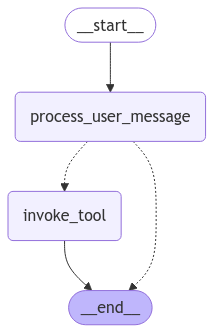


=== Demo #1: Check Weather ===

--- Final Messages #1 ---
================================ Human Message =================================

I would like the weather for North Bethesda, MD.
================================== Ai Message ==================================
Tool Calls:
  check_weather (call_SRwmMejB308SJFYoS5w9U7n2)
 Call ID: call_SRwmMejB308SJFYoS5w9U7n2
  Args:
    location: North Bethesda, MD

=== Demo #2: Retrieve Last Recorded Temperature ===

--- Final Messages #2 ---
================================ Human Message =================================

What was the last recorded temperature?
================================== Ai Message ==================================
Tool Calls:
  get_last_temperature (call_sh7VdyVLeKZ5gOwsvcyVMTW4)
 Call ID: call_sh7VdyVLeKZ5gOwsvcyVMTW4
  Args:

=== Memory Log Contents ===
{
  "2025-02-18 13": [
    "North Bethesda, MD",
    24.0
  ],
  "2025-02-18 15": [
    "North Bethesda, MD",
    24.0
  ],
  "2025-02-18 18": [
    "North Bethe

In [14]:
import os
import requests
import json
from datetime import datetime
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

##############################################################################
# 1) Environment & Basic Setup
##############################################################################
load_dotenv()

def get_env_var(var: str):
    """Fetches environment variables or raises an error if missing."""
    value = os.getenv(var)
    if value is None:
        raise ValueError(f"{var} not found in environment variables. Check .env.")
    return value

openai_api_key = get_env_var("OPENAI_API_KEY")

##############################################################################
# 2) File-Based Hourly Weather Memory
##############################################################################
class FileHourlyWeatherMemory:
    """Persistent weather memory storing hourly weather data in a JSON file."""

    def __init__(self, file_path="weather_memory.json"):
        self.file_path = file_path
        self.hourly_log = self._load_from_file()

    def store_temperature(self, location: str, temp_f: float):
        """Stores temperature reading for the current hour."""
        now = datetime.now().strftime('%Y-%m-%d %H')
        cleaned_location = location.strip().replace(".", "")  # Clean formatting
        self.hourly_log[now] = (cleaned_location, temp_f)
        self._save_to_file()

    def get_last_logged_temperature(self):
        """Returns the most recent logged temperature, or None if no data exists."""
        if not self.hourly_log:
            return None
        latest_hour = max(self.hourly_log.keys())
        loc, temp = self.hourly_log[latest_hour]
        return latest_hour, loc, temp

    def _save_to_file(self):
        with open(self.file_path, "w", encoding="utf-8") as f:
            json.dump(self.hourly_log, f)

    def _load_from_file(self):
        if not os.path.exists(self.file_path):
            return {}
        with open(self.file_path, "r", encoding="utf-8") as f:
            return json.load(f)

weather_memory = FileHourlyWeatherMemory()

##############################################################################
# 3) Weather API & Tools (Now Used as GPT Function Calls)
##############################################################################
def check_weather(location: str) -> dict:
    """Fetches real-time weather from wttr.in and logs it in memory."""
    try:
        loc = location.strip().replace(" ", "+")
        url = f"https://wttr.in/{loc}?format=j1"
        resp = requests.get(url, timeout=10)

        if resp.status_code == 200:
            data = resp.json()
            current_temp_f = float(data["current_condition"][0]["temp_F"])
            weather_memory.store_temperature(location, current_temp_f)
            return {"location": location, "temperature": current_temp_f, "status": "success"}

        return {"status": "error", "message": f"Couldn't fetch the weather (HTTP {resp.status_code})."}

    except Exception as e:
        return {"status": "error", "message": f"Error fetching weather: {e}"}

def get_last_temperature() -> dict:
    """Retrieves the last recorded temperature from stored logs."""
    last_logged = weather_memory.get_last_logged_temperature()
    
    if last_logged:
        last_hour, loc, temp = last_logged
        return {"location": loc, "temperature": temp, "time": last_hour, "status": "success"}
    
    return {"status": "error", "message": "No temperature data available."}

##############################################################################
# 4) OpenAI-Powered Chat Agent
##############################################################################
llm = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=openai_api_key)
llm_with_tools = llm.bind_tools([check_weather, get_last_temperature])

##############################################################################
# 5) Define Nodes
##############################################################################
def process_user_message(state: MessagesState):
    """Uses GPT to process user messages and decide whether to call a tool or respond."""
    response = llm_with_tools.invoke(state["messages"])
    state["messages"].append(response)
    return {"messages": state["messages"]}

##############################################################################
# 6) Routing Logic
##############################################################################
def decide_next_step(state: MessagesState):
    """Decides if the LLM should call a tool or generate a response."""
    last_ai_msg = state["messages"][-1]

    if isinstance(last_ai_msg, ToolMessage):
        return ["invoke_tool"]

    return [END]

##############################################################################
# 7) Build the AI-Powered Chat Agent
##############################################################################
builder = StateGraph(MessagesState)
builder.add_node("process_user_message", process_user_message)
builder.add_node("invoke_tool", ToolNode([check_weather, get_last_temperature]))

builder.add_edge(START, "process_user_message")
builder.add_conditional_edges("process_user_message", decide_next_step)
builder.add_edge("invoke_tool", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

##############################################################################
# 8) Demo 1: Check Weather
##############################################################################
print("\n=== Demo #1: Check Weather ===")
messages1 = [
    HumanMessage(content="I would like the weather for North Bethesda, MD.")
]
result1 = graph.invoke({"messages": messages1})
print("\n--- Final Messages #1 ---")
for msg in result1["messages"]:
    msg.pretty_print()

##############################################################################
# 9) Demo 2: Retrieve Last Recorded Temperature
##############################################################################
print("\n=== Demo #2: Retrieve Last Recorded Temperature ===")
messages2 = [
    HumanMessage(content="What was the last recorded temperature?")
]
result2 = graph.invoke({"messages": messages2})
print("\n--- Final Messages #2 ---")
for msg in result2["messages"]:
    msg.pretty_print()

##############################################################################
# 10) Inspect the JSON Log
##############################################################################
print("\n=== Memory Log Contents ===")
print(json.dumps(weather_memory.hourly_log, indent=2))


🌍 Starting weather monitor for North Bethesda, MD every 30 minutes...


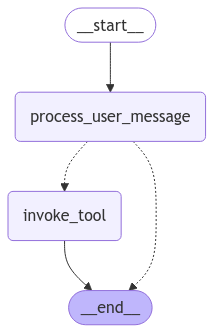


=== Demo #1: Check Weather ===

--- Final Messages #1 ---
================================ Human Message =================================

I would like the weather for North Bethesda, MD.
================================== Ai Message ==================================
Tool Calls:
  check_weather (call_hrjlNdy7bf7JL1CaH9ZyZc79)
 Call ID: call_hrjlNdy7bf7JL1CaH9ZyZc79
  Args:
    location: North Bethesda, MD

=== Demo #2: Retrieve Last Recorded Temperature ===

--- Final Messages #2 ---
================================ Human Message =================================

What was the last recorded temperature?
================================== Ai Message ==================================
Tool Calls:
  get_last_temperature (call_dxEwxPM8BlMdbmHpypX2o6fc)
 Call ID: call_dxEwxPM8BlMdbmHpypX2o6fc
  Args:


In [15]:
import os
import requests
import json
import time
import threading
from datetime import datetime
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

##############################################################################
# 1) Environment & Basic Setup
##############################################################################
load_dotenv()

def get_env_var(var: str):
    """Fetches environment variables or raises an error if missing."""
    value = os.getenv(var)
    if value is None:
        raise ValueError(f"{var} not found in environment variables. Check .env.")
    return value

openai_api_key = get_env_var("OPENAI_API_KEY")

##############################################################################
# 2) File-Based Hourly Weather Memory
##############################################################################
class FileHourlyWeatherMemory:
    """Persistent weather memory storing hourly weather data in a JSON file."""

    def __init__(self, file_path="weather_memory.json"):
        self.file_path = file_path
        self.hourly_log = self._load_from_file()

    def store_temperature(self, location: str, temp_f: float):
        """Stores temperature reading for the current hour."""
        now = datetime.now().strftime('%Y-%m-%d %H')
        cleaned_location = location.strip().replace(".", "")  # Clean formatting
        self.hourly_log[now] = (cleaned_location, temp_f)
        self._save_to_file()

    def get_last_logged_temperature(self):
        """Returns the most recent logged temperature, or None if no data exists."""
        if not self.hourly_log:
            return None
        latest_hour = max(self.hourly_log.keys())
        loc, temp = self.hourly_log[latest_hour]
        return latest_hour, loc, temp

    def _save_to_file(self):
        with open(self.file_path, "w", encoding="utf-8") as f:
            json.dump(self.hourly_log, f)

    def _load_from_file(self):
        if not os.path.exists(self.file_path):
            return {}
        with open(self.file_path, "r", encoding="utf-8") as f:
            return json.load(f)

weather_memory = FileHourlyWeatherMemory()

##############################################################################
# 3) Weather API & Tools (Now Used as GPT Function Calls)
##############################################################################
def check_weather(location: str) -> dict:
    """Fetches real-time weather from wttr.in and logs it in memory."""
    try:
        loc = location.strip().replace(" ", "+")
        url = f"https://wttr.in/{loc}?format=j1"
        resp = requests.get(url, timeout=10)

        if resp.status_code == 200:
            data = resp.json()
            current_temp_f = float(data["current_condition"][0]["temp_F"])
            weather_memory.store_temperature(location, current_temp_f)
            return {"location": location, "temperature": current_temp_f, "status": "success"}

        return {"status": "error", "message": f"Couldn't fetch the weather (HTTP {resp.status_code})."}

    except Exception as e:
        return {"status": "error", "message": f"Error fetching weather: {e}"}

def get_last_temperature() -> dict:
    """Retrieves the last recorded temperature from stored logs."""
    last_logged = weather_memory.get_last_logged_temperature()
    
    if last_logged:
        last_hour, loc, temp = last_logged
        return {"location": loc, "temperature": temp, "time": last_hour, "status": "success"}
    
    return {"status": "error", "message": "No temperature data available."}

##############################################################################
# 4) Send Notification (Optional: Replace with Twilio, Email, or Slack)
##############################################################################
def send_notification(message: str):
    """Send a notification when weather changes (console-based for now)."""
    print(f"\n🔔 WEATHER ALERT: {message}\n")

##############################################################################
# 5) Background Task: Check Weather Periodically
##############################################################################
def monitor_weather(location: str, interval=1800, threshold=2.0):
    """
    Periodically checks the weather for `location` every `interval` seconds.
    If the temperature changes by more than `threshold`, sends a notification.
    """
    print(f"🌍 Starting weather monitor for {location} every {interval // 60} minutes...")

    while True:
        latest_data = check_weather(location)

        if latest_data["status"] == "success":
            last_logged = weather_memory.get_last_logged_temperature()
            
            if last_logged:
                last_hour, last_loc, last_temp = last_logged

                # Compare new temp with last recorded temp
                temp_diff = abs(last_temp - latest_data["temperature"])
                if temp_diff >= threshold:
                    send_notification(f"Temperature in {location} changed from {last_temp}°F to {latest_data['temperature']}°F!")

        time.sleep(interval)  # Wait before checking again

# Run in a background thread
monitor_thread = threading.Thread(target=monitor_weather, args=("North Bethesda, MD",), daemon=True)
monitor_thread.start()

##############################################################################
# 6) OpenAI-Powered Chat Agent
##############################################################################
llm = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=openai_api_key)
llm_with_tools = llm.bind_tools([check_weather, get_last_temperature])

##############################################################################
# 7) Define Nodes
##############################################################################
def process_user_message(state: MessagesState):
    """Uses GPT to process user messages and decide whether to call a tool or respond."""
    response = llm_with_tools.invoke(state["messages"])
    state["messages"].append(response)
    return {"messages": state["messages"]}

##############################################################################
# 8) Routing Logic
##############################################################################
def decide_next_step(state: MessagesState):
    """Decides if the LLM should call a tool or generate a response."""
    last_ai_msg = state["messages"][-1]

    if isinstance(last_ai_msg, ToolMessage):
        return ["invoke_tool"]

    return [END]

##############################################################################
# 9) Build the AI-Powered Chat Agent
##############################################################################
builder = StateGraph(MessagesState)
builder.add_node("process_user_message", process_user_message)
builder.add_node("invoke_tool", ToolNode([check_weather, get_last_temperature]))

builder.add_edge(START, "process_user_message")
builder.add_conditional_edges("process_user_message", decide_next_step)
builder.add_edge("invoke_tool", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

##############################################################################
# 10) Demo 1: Check Weather
##############################################################################
print("\n=== Demo #1: Check Weather ===")
messages1 = [
    HumanMessage(content="I would like the weather for North Bethesda, MD.")
]
result1 = graph.invoke({"messages": messages1})
print("\n--- Final Messages #1 ---")
for msg in result1["messages"]:
    msg.pretty_print()

##############################################################################
# 11) Demo 2: Retrieve Last Recorded Temperature
##############################################################################
print("\n=== Demo #2: Retrieve Last Recorded Temperature ===")
messages2 = [
    HumanMessage(content="What was the last recorded temperature?")
]
result2 = graph.invoke({"messages": messages2})
print("\n--- Final Messages #2 ---")
for msg in result2["messages"]:
    msg.pretty_print()
